In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cluster_log_transform import Cluster_Log
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    f1_score, classification_report, roc_curve,
    roc_auc_score, recall_score
)
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', 100)


In [6]:
df = pd.read_csv("online_shoppers_intention.csv")

num_cat_cols = ["OperatingSystems", "Browser", "Region", "TrafficType"]
df[num_cat_cols] = df[num_cat_cols].astype("category")


cleaned_df = df.drop_duplicates().reset_index(drop=True)
# Categorical dummies
cat_cols = ["Month", "OperatingSystems", "Browser", "Region", "TrafficType", "VisitorType", "Weekend"]

dummy_cols = pd.get_dummies(cleaned_df[cat_cols])

# x and y
X = cleaned_df.iloc[:, :-1]
Y = cleaned_df.iloc[:, -1]

# replace cat columns with encoded dummies
X = pd.concat([X.drop(columns=cat_cols), dummy_cols.astype(int)], axis=1)

# numeric columns for Cluster_Log
num_df = cleaned_df.select_dtypes(include=["int64", "float64"])
num_cols = num_df.columns

# Preprocessing pipeline
preprocessor = ColumnTransformer([("add_clusters_and_log", Cluster_Log(k=5), num_cols)],remainder="passthrough")

In [7]:
# baseline svm

In [8]:
svm_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", SVC(probability=True))
])

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, stratify=Y, test_size=0.2, random_state=88, shuffle=True
)

vanilla_svm = svm_pipe.fit(X_train, Y_train)

y_pred = vanilla_svm.predict(X_test)
y_proba = vanilla_svm.predict_proba(X_test)[:, 1]

vanilla_f1 = f1_score(Y_test, y_pred, average="weighted")
recall_minority = recall_score(Y_test, y_pred)
adjusted_f1 = vanilla_f1 * recall_minority

In [9]:
print(f"Vanilla SVM Weighted F1 Score: {vanilla_f1:.3f}")
print(f"Vanilla SVM Adjusted F1 Score: {adjusted_f1:.3f}\n")

print("Vanilla SVM Classification Report")
print(classification_report(Y_test, y_pred, target_names=["No Purchase Made", "Purchase Made"]))

Vanilla SVM Weighted F1 Score: 0.873
Vanilla SVM Adjusted F1 Score: 0.336

Vanilla SVM Classification Report
                  precision    recall  f1-score   support

No Purchase Made       0.90      0.98      0.94      2059
   Purchase Made       0.82      0.38      0.52       382

        accuracy                           0.89      2441
       macro avg       0.86      0.68      0.73      2441
    weighted avg       0.88      0.89      0.87      2441



Vanilla SVM AUC Score: 0.842


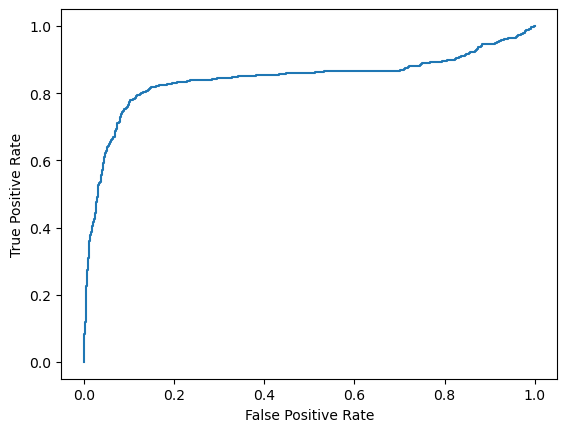

In [10]:
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

plot_roc_curve(Y_test, y_proba)
print(f"Vanilla SVM AUC Score: {roc_auc_score(Y_test, y_proba):.3f}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



SMOTE SVM Weighted F1 Score: 0.896
SMOTE SVM Adjusted F1 Score: 0.567

SMOTE SVM Classification Report
                  precision    recall  f1-score   support

No Purchase Made       0.93      0.95      0.94      2059
   Purchase Made       0.69      0.63      0.66       382

        accuracy                           0.90      2441
       macro avg       0.81      0.79      0.80      2441
    weighted avg       0.89      0.90      0.90      2441

SMOTE SVM AUC Score: 0.896


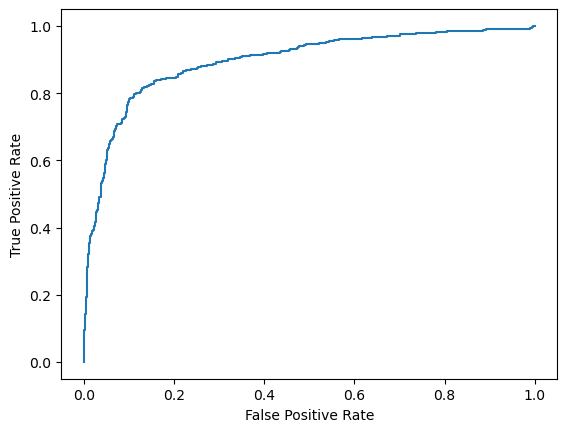

In [12]:
# smote + svm
smote = SMOTE(random_state=88, sampling_strategy=0.6)
X_train_res, Y_train_res = smote.fit_resample(X_train, Y_train)

svm_smote = svm_pipe.fit(X_train_res, Y_train_res)

y_pred_sm = svm_smote.predict(X_test)
y_proba_sm = svm_smote.predict_proba(X_test)[:, 1]

sm_f1 = f1_score(Y_test, y_pred_sm, average="weighted")
sm_adj_f1 = sm_f1 * recall_score(Y_test, y_pred_sm)

print(f"\nSMOTE SVM Weighted F1 Score: {sm_f1:.3f}")
print(f"SMOTE SVM Adjusted F1 Score: {sm_adj_f1:.3f}\n")

print("SMOTE SVM Classification Report")
print(classification_report(Y_test, y_pred_sm, target_names=["No Purchase Made", "Purchase Made"]))

plot_roc_curve(Y_test, y_proba_sm)
print(f"SMOTE SVM AUC Score: {roc_auc_score(Y_test, y_proba_sm):.3f}")

In [13]:
# grid search 
svm_search_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", SVC(probability=False))])

param_grid_optimized = [
    {"classifier__C": [0.1, 1, 10], "classifier__kernel": ["linear"]},
    {"classifier__C": [1, 10, 50], "classifier__kernel": ["rbf"], "classifier__gamma": ["scale", 0.1]}
]

grid_svm = GridSearchCV(
    estimator=svm_search_pipe,
    param_grid=param_grid_optimized,
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
    verbose=3)

grid_svm.fit(X_train, Y_train)
print(f"Best Params: {grid_svm.best_params_}")

best_params = grid_svm.best_params_
final_C = best_params["classifier__C"]
final_kernel = best_params["classifier__kernel"]
final_gamma = best_params.get("classifier__gamma", "scale")

print("\nTraining final model with probabilities")

final_svm_pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", SVC(C=final_C,kernel=final_kernel,gamma=final_gamma,probability=True))])

final_svm_pipe.fit(X_train, Y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END classifier__C=1, classifier__gamma=scale, classifier__kernel=rbf;, score=0.856 total time=   1.8s
[CV 1/3] END classifier__C=1, classifier__gamma=scale, classifier__kernel=rbf;, score=0.861 total time=   1.9s
[CV 3/3] END classifier__C=1, classifier__gamma=scale, classifier__kernel=rbf;, score=0.866 total time=   1.6s
[CV 1/3] END classifier__C=1, classifier__gamma=0.1, classifier__kernel=rbf;, score=0.828 total time=   3.0s
[CV 2/3] END classifier__C=1, classifier__gamma=0.1, classifier__kernel=rbf;, score=0.828 total time=   2.9s
[CV 1/3] END classifier__C=10, classifier__gamma=scale, classifier__kernel=rbf;, score=0.874 total time=   1.5s
[CV 3/3] END classifier__C=1, classifier__gamma=0.1, classifier__kernel=rbf;, score=0.827 total time=   3.0s
[CV 2/3] END classifier__C=10, classifier__gamma=scale, classifier__kernel=rbf;, score=0.873 total time=   1.5s
[CV 3/3] END classifier__C=10, classifier__gamma=scale, 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('add_clusters_and_log',
                                                  Cluster_Log(),
                                                  Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'],
      dtype='object'))])),
                ('classifier', SVC(C=50, probability=True))])

Tuned SVM Weighted F1: 0.883
Tuned SVM Adjusted F1: 0.428
Tuned SVM AUC Score: 0.836

Tuned SVM Classification Report
              precision    recall  f1-score   support

 No Purchase       0.91      0.97      0.94      2059
    Purchase       0.74      0.48      0.59       382

    accuracy                           0.89      2441
   macro avg       0.83      0.73      0.76      2441
weighted avg       0.88      0.89      0.88      2441

Tuned SVM AUC Score: 0.836


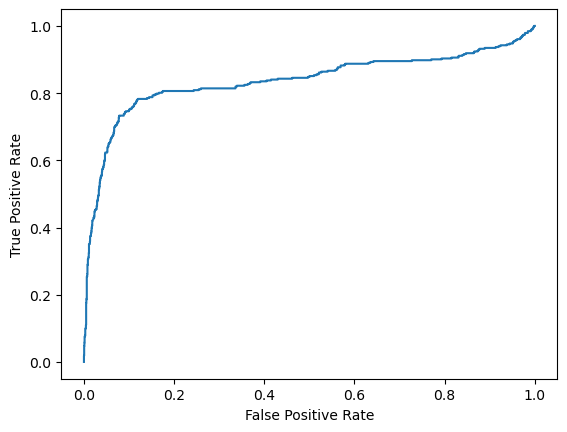

In [14]:
y_pred_final = final_svm_pipe.predict(X_test)
y_proba_final = final_svm_pipe.predict_proba(X_test)[:, 1]

final_f1 = f1_score(Y_test, y_pred_final, average="weighted")
final_adj_f1 = final_f1 * recall_score(Y_test, y_pred_final)
final_auc = roc_auc_score(Y_test, y_proba_final)

print(f"Tuned SVM Weighted F1: {final_f1:.3f}")
print(f"Tuned SVM Adjusted F1: {final_adj_f1:.3f}")
print(f"Tuned SVM AUC Score: {final_auc:.3f}\n")

print("Tuned SVM Classification Report")
print(classification_report(Y_test, y_pred_final, target_names=["No Purchase", "Purchase"]))

plot_roc_curve(Y_test, y_proba_final)
print(f"Tuned SVM AUC Score: {final_auc:.3f}")